## References: 
https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21  
https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24   
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
# !pip install gensim
# !pip install pyLDAvis

In [2]:
import pandas as pd
from gensim import corpora
import pickle
import gensim
import ast
import pyLDAvis.gensim
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../Dataset/preprocessed_text.csv')
print(df.shape)
df.head()

(29210, 9)


,Unnamed: 0,tweet_text,timestamp,id,user,Party,hashtag,text,Segmented#
0,2998,🌞Reminder on this sunny day - if you’re taking...,2020-03-26 17:25:23,1.243228e+18,delaware_gov,0,[],"['reminder', 'sunny', 'day', 'taking', 'kid', ...",NaN
1,19729,"🎥 In one hour, I'll hold a virtual press confe...",2020-03-31 17:30:25,1.245041e+18,GovHolcomb,1,['COVID19'],"['one', 'hour', 'ill', 'hold', 'virtual', 'pre...",covid 19
2,3075,RT @CDCgov: Practice social distancing by putt...,2020-03-18 11:41:14,1.240242e+18,delaware_gov,0,[],"['practice', 'social', 'distancing', 'putting'...",NaN
3,28816,"Earlier today, I wrote to @POTUS asking him to...",2020-03-27 22:40:51,1.243669e+18,GovPhilScott,1,[],"['earlier', 'today', 'wrote', 'asking', 'invok...",NaN
4,6507,We have created a website to mobilize healthca...,2020-03-28 23:14:20,1.244040e+18,LouisianaGov,0,[],"['created', 'website', 'mobilize', 'healthcare...",NaN


In [4]:
text_data = list(df['text'].apply(ast.literal_eval))

In [5]:
#Creating and saving BOW dictionary
# dictionary = corpora.Dictionary(text_data)
# dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000) #Remove most common and most rare words
# corpus = [dictionary.doc2bow(text) for text in text_data]
# pickle.dump(corpus, open('corpus.pkl', 'wb'))
# dictionary.save('dictionary.gensim')

### To determine the best number of topics, we plot the coherence of topics for a range of values

In [6]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, random_state=20)
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [7]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=text_data, start=5, limit=100, step=5)

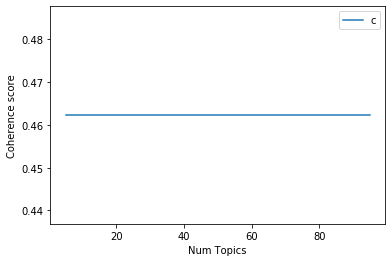

In [8]:
limit=100; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### The ideal number of models has high coherence, but values that are too large will have more overlap between topics. To balance coherence and overlap, we chose number of topics to be 25

In [9]:
# Training and saving model so it can be loaded next time
# ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 25, id2word=dictionary, random_state = 20)
# ldamodel.save('model25.gensim')


In [10]:
lda = gensim.models.ldamodel.LdaModel.load('model25.gensim')
topics = lda.print_topics(num_words=5)
for topic in topics:
    print(topic)

(10, '0.039*"grateful" + 0.038*"leadership" + 0.028*"economic" + 0.026*"honor" + 0.025*"u"')
(7, '0.097*"health" + 0.075*"public" + 0.054*"state" + 0.040*"official" + 0.036*"county"')
(21, '0.048*"life" + 0.039*"national" + 0.023*"put" + 0.022*"night" + 0.021*"woman"')
(22, '0.066*"get" + 0.046*"together" + 0.036*"need" + 0.029*"make" + 0.028*"come"')
(12, '0.075*"year" + 0.070*"great" + 0.037*"day" + 0.037*"today" + 0.026*"last"')
(19, '0.082*"spread" + 0.035*"food" + 0.031*"service" + 0.030*"help" + 0.027*"slow"')
(23, '0.049*"know" + 0.043*"right" + 0.038*"good" + 0.023*"unemployment" + 0.022*"need"')
(17, '0.038*"hand" + 0.028*"health" + 0.027*"helping" + 0.027*"special" + 0.022*"funding"')
(13, '0.048*"today" + 0.043*"state" + 0.037*"announced" + 0.028*"happy" + 0.021*"capacity"')
(1, '0.084*"business" + 0.040*"small" + 0.035*"testing" + 0.032*"available" + 0.025*"k"')
(20, '0.044*"work" + 0.039*"community" + 0.034*"tonight" + 0.029*"hard" + 0.023*"state"')
(3, '0.098*"update" + 0

In [11]:
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

### We then find the most likely topic for each document and save the resulting dataframe so that it can be directly loaded later.

In [12]:
# topic_dist = map(lda.get_document_topics, corpus)
# topic_distribution = list(topic_dist)
# topic_dicts = [dict(i) for i in topic_distribution]
# dist_df = pd.DataFrame.from_dict(topic_dicts, orient = 'columns')
# dist_df['Party'] = df['Party']

# col_names = {}
# for i in range(lda.num_topics):
#     name = 'Topic '+str(i+1)
#     col_names[i] = name

# dist_df.rename(columns=col_names, inplace=True)
# dist_df['Most Likely Topic'] = dist_df[list(col_names.values())].idxmax(axis = 1)

# dist_df.to_pickle('TopicDistribution_ntopics.pkl')
# dist_df.to_csv('TopicDistribution_ntopics.csv')

In [13]:
dist_df = pd.read_pickle('TopicDistribution_ntopics.pkl')
dist_df['Most Likely Topic']

0        Topic 25
1         Topic 4
2         Topic 3
3        Topic 14
4        Topic 22
           ...   
29205     Topic 4
29206    Topic 13
29207    Topic 10
29208    Topic 10
29209    Topic 23
Name: Most Likely Topic, Length: 29210, dtype: object

Text(0.5, 1.0, 'Relative proportion of documents of each class per topic')

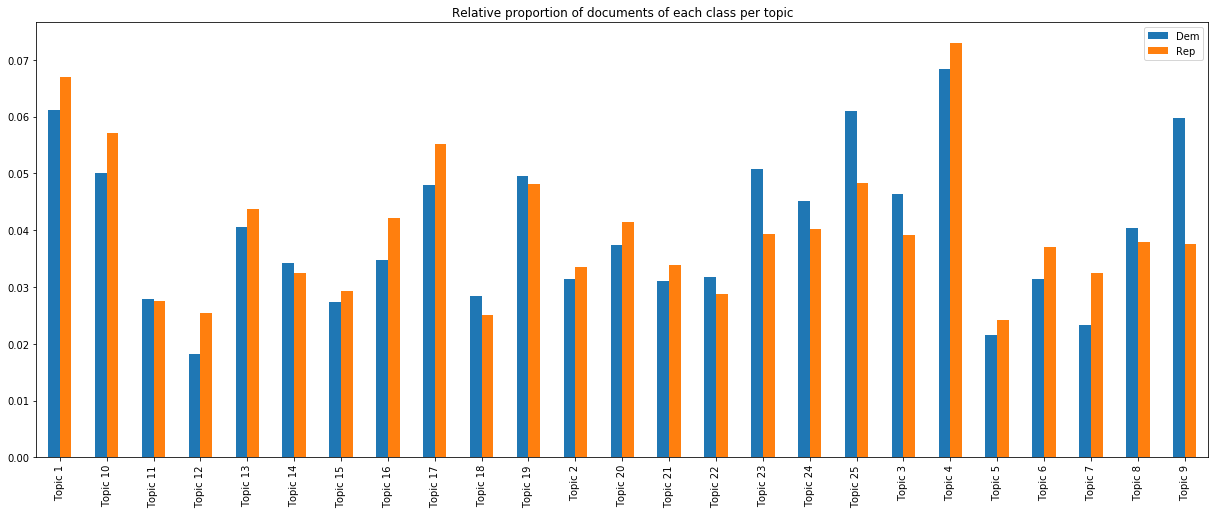

In [14]:
rep_dist = dist_df[dist_df['Party'] == 1]['Most Likely Topic'].value_counts(normalize = True)
dem_dist = dist_df[dist_df['Party'] == 0]['Most Likely Topic'].value_counts(normalize = True)
party_dist = pd.DataFrame({'Dem': dem_dist, 'Rep': rep_dist})

party_dist.plot(kind = 'bar', figsize = (21,8))
plt.title('Relative proportion of documents of each class per topic')

In [21]:
#More Democrat
print("Topic 9:")
lda.show_topic(8, topn = 15)

Topic 9:


[('case', 0.09473943),
 ('covid', 0.055911776),
 ('positive', 0.05280826),
 ('new', 0.045474622),
 ('virus', 0.03592845),
 ('number', 0.031309113),
 ('test', 0.030668672),
 ('ha', 0.02886002),
 ('confirmed', 0.026757639),
 ('total', 0.026725989),
 ('additional', 0.025180392),
 ('today', 0.021452447),
 ('update', 0.017610434),
 ('outbreak', 0.017215677),
 ('bringing', 0.016911447)]

In [22]:
#More Democrat
print("Topic 25:")
lda.show_topic(24, topn = 15)

Topic 25:


[('home', 0.103613004),
 ('stay', 0.093284115),
 ('go', 0.027111059),
 ('visit', 0.025612395),
 ('resource', 0.025394218),
 ('child', 0.02383181),
 ('staying', 0.021865606),
 ('please', 0.01760607),
 ('care', 0.017296314),
 ('need', 0.015967112),
 ('decision', 0.014360831),
 ('website', 0.013843488),
 ('new', 0.013236529),
 ('healthy', 0.013129655),
 ('order', 0.01260836)]

In [23]:
#More Republican
print("Topic 10:")
lda.show_topic(9, topn = 15)

Topic 10:


[('governor', 0.048836682),
 ('response', 0.044979203),
 ('covid', 0.03684646),
 ('live', 0.03517588),
 ('update', 0.034178544),
 ('join', 0.033954553),
 ('latest', 0.03125949),
 ('share', 0.03059925),
 ('discus', 0.030401288),
 ('gov', 0.028132072),
 ('director', 0.027411923),
 ('today', 0.027152184),
 ('p', 0.02568485),
 ('information', 0.024971785),
 ('daily', 0.024152312)]

In [24]:
#More Republican
print("Topic 17:")
lda.show_topic(16, topn = 15)

Topic 17:


[('order', 0.08170491),
 ('executive', 0.044353906),
 ('today', 0.037707966),
 ('taking', 0.031822268),
 ('every', 0.02565329),
 ('signed', 0.02403721),
 ('issued', 0.023805685),
 ('action', 0.022948187),
 ('measure', 0.017799875),
 ('gov', 0.015763458),
 ('may', 0.015416666),
 ('volunteer', 0.014580008),
 ('step', 0.013904142),
 ('business', 0.0138418805),
 ('day', 0.013474103)]

In [25]:
#Equal
print("Topic 11:")
lda.show_topic(10, topn = 15)

Topic 11:


[('grateful', 0.039147273),
 ('leadership', 0.037988354),
 ('economic', 0.028181016),
 ('honor', 0.02552756),
 ('u', 0.024746377),
 ('happening', 0.023143405),
 ('time', 0.021570664),
 ('program', 0.021161648),
 ('building', 0.018188545),
 ('today', 0.017735831),
 ('info', 0.01723672),
 ('protection', 0.015952658),
 ('fighting', 0.015580314),
 ('thank', 0.015579761),
 ('f', 0.014875453)]